In [110]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import START,END,StateGraph
from pydantic import BaseModel,Field
from dotenv import load_dotenv
from typing import TypedDict,Annotated
import operator
import os
load_dotenv()

True

In [111]:
# loading the model
api_key=os.getenv('GOOGLE_API_KEY')
model=ChatGoogleGenerativeAI(model='gemini-2.5-flash-lite-preview-09-2025',temperature=0.2,api_key=api_key)

In [112]:
# For Structured Output
class EvaluationSchema(BaseModel):
    rate:float=Field(le=5.0,ge=1.0,description='Individual rating of the essay.')
    feedback:str=Field(description='Detailed feedback of the essay')

In [113]:
# Structured Model 
structured_model=model.with_structured_output(EvaluationSchema)

In [114]:
response=structured_model.invoke("""
Democracy is a system built on the belief that power should belong to the people rather than a single ruler or elite group. At its heart lies the idea of participation—citizens have the right to choose their leaders, question authority, and influence the decisions that shape their lives. It thrives on dialogue, accountability, and the constant negotiation between freedom and responsibility.

However, democracy is not a static structure; it’s a living process. It demands informed citizens, active debate, and respect for differing opinions. When people become apathetic or when misinformation spreads unchecked, democracy weakens, tilting toward populism or authoritarianism. Its strength depends less on the laws written in constitutions and more on the habits of its citizens—their willingness to listen, compromise, and hold truth above convenience.

In the modern world, democracy faces new tests: digital manipulation, economic inequality, and the growing divide between global and local interests. Yet its resilience endures because it adapts. The promise of democracy is not perfection but progress—the collective pursuit of justice, equality, and dignity for all.
""")

In [115]:
response

EvaluationSchema(rate=4.5, feedback='The essay provides a concise and well-structured overview of democracy. It effectively captures the core principles (participation, accountability) and acknowledges its dynamic nature, highlighting the necessary role of informed citizens. The conclusion neatly summarizes the ongoing challenges and the enduring promise of democracy. The language is clear and persuasive.')

In [116]:
class EssayState(TypedDict):

    essay:str
    language_feedback:str
    analysis_feedback:str
    clarity_feedback:str
    overall_feedback:str
    individual_scores:Annotated[list[int],operator.add]
    avg_score:float


In [117]:
def evaluate_language(state:EssayState):
    essay=state['essay']
    prompt=f'Evaluate the language quality of the following essay and provide the feedback provide a score upto 5.\n{essay}'
    output=structured_model.invoke(prompt)
    return {'language_feedback':output.feedback,'individual_scores':[output.rate]}

In [118]:
def clarity_feedback(state:EssayState):
    essay=state['essay']
    prompt=f'Evaluate the clarity feedback of the following essay and provide the feedback provide a score upto 5.\n{essay}'
    output=structured_model.invoke(prompt)
    return {'clarity_feedback':output.feedback,'individual_scores':[output.rate]}

In [119]:
def analysis_feedback(state:EssayState):
    essay=state['essay']
    prompt=f'Evaluate the depth analysis of the following essay and provide the feedback provide a score upto 5.\n{essay}'
    output=structured_model.invoke(prompt)
    return {'analysis_feedback':output.feedback,'individual_scores':[output.rate]}

In [126]:
def final_evaluation(state:EssayState):
    language_feedback=state['language_feedback']
    clarity_feedback=state['clarity_feedback']
    analysis_feedback=state['analysis_feedback']

    prompt=f'Give me the summarized feedback of the model using the given language feedback {language_feedback}\n , clarity_feedback {clarity_feedback}\n and the in depth analysis feedback {analysis_feedback}.'
    response=structured_model.invoke(prompt)
    avg_score=sum(state['individual_scores'])/len(state['individual_scores'])
    return {'overall_feedback':response.feedback,'avg_score':avg_score}

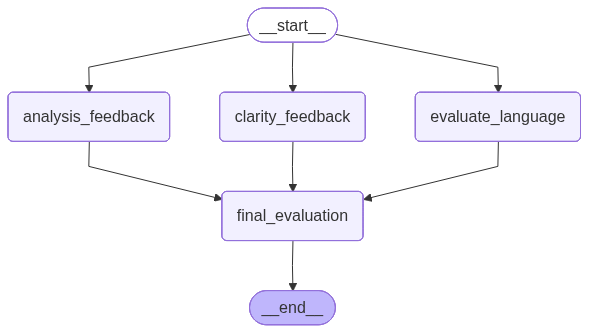

In [127]:
# make the graph

graph=StateGraph(EssayState)

# make the nodes
graph.add_node('evaluate_language',evaluate_language)
graph.add_node('clarity_feedback',clarity_feedback)
graph.add_node('analysis_feedback',analysis_feedback)
graph.add_node('final_evaluation',final_evaluation)


# make the edges
graph.add_edge(START,'evaluate_language')
graph.add_edge(START,'clarity_feedback')
graph.add_edge(START,'analysis_feedback')

graph.add_edge('evaluate_language','final_evaluation')
graph.add_edge('clarity_feedback','final_evaluation')
graph.add_edge('analysis_feedback','final_evaluation')

graph.add_edge('final_evaluation',END)

# compile the workflow
workflow=graph.compile()
workflow


In [128]:
# Initial State
initial_state={
    'essay':''' 
Democracy is a system built on the belief that power should belong to the people rather than a single ruler or elite group. At its heart lies the idea of participation—citizens have the right to choose their leaders, question authority, and influence the decisions that shape their lives. It thrives on dialogue, accountability, and the constant negotiation between freedom and responsibility.

However, democracy is not a static structure; it’s a living process. It demands informed citizens, active debate, and respect for differing opinions. When people become apathetic or when misinformation spreads unchecked, democracy weakens, tilting toward populism or authoritarianism. Its strength depends less on the laws written in constitutions and more on the habits of its citizens—their willingness to listen, compromise, and hold truth above convenience.

In the modern world, democracy faces new tests: digital manipulation, economic inequality, and the growing divide between global and local interests. Yet its resilience endures because it adapts. The promise of democracy is not perfection but progress—the collective pursuit of justice, equality, and dignity for all.
'''
}

# Executing the graph
output_state=workflow.invoke(initial_state)
output_state

{'essay': ' \nDemocracy is a system built on the belief that power should belong to the people rather than a single ruler or elite group. At its heart lies the idea of participation—citizens have the right to choose their leaders, question authority, and influence the decisions that shape their lives. It thrives on dialogue, accountability, and the constant negotiation between freedom and responsibility.\n\nHowever, democracy is not a static structure; it’s a living process. It demands informed citizens, active debate, and respect for differing opinions. When people become apathetic or when misinformation spreads unchecked, democracy weakens, tilting toward populism or authoritarianism. Its strength depends less on the laws written in constitutions and more on the habits of its citizens—their willingness to listen, compromise, and hold truth above convenience.\n\nIn the modern world, democracy faces new tests: digital manipulation, economic inequality, and the growing divide between gl

In [130]:
output_state['overall_feedback']

'The essay is exceptionally well-written, demonstrating strong structure, sophisticated vocabulary, and excellent clarity. It effectively defines democracy as a "living process" and logically moves through its core principles, challenges, and enduring promise. The analysis accurately identifies key elements like participation and accountability and touches upon modern threats such as digital manipulation.\n\n**Key Strengths:** Clarity, structure, precise language, and accurate conceptual overview.\n\n**Area for Improvement (Limiting Depth):** The analysis remains largely abstract. To achieve a deeper analytical score, the essay would benefit from incorporating specific, brief examples to illustrate the threats mentioned (e.g., digital manipulation) and exploring the *mechanisms* of adaptation or the inherent trade-offs within democratic governance in more detail. It is a strong descriptive analysis but stops short of deep, evidence-based argumentation.'